In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections, random

from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt



#Hyperparameters
lr_pi           = 0.0005
lr_q            = 0.001
init_alpha      = 0.01
gamma           = 0.98
batch_size      = 32
buffer_limit    = 50000
tau             = 0.01 # for target network soft update
target_entropy  = -1.0 # for automated alpha update
lr_alpha        = 0.001  # for automated alpha update

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

class PolicyNet(nn.Module):
    def __init__(self, learning_rate):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.log_alpha = torch.tensor(np.log(init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_alpha)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

class QNet(nn.Module):
    def __init__(self, learning_rate):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64)
        self.fc_a = nn.Linear(1,64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a) , target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

def calc_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch

    with torch.no_grad():
        a_prime, log_prob= pi(s_prime)
        entropy = -pi.log_alpha.exp() * log_prob
        q1_val, q2_val = q1(s_prime,a_prime), q2(s_prime,a_prime)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]
        target = r + gamma * done * (min_q + entropy)

    return target
    
env = gym.make('Pendulum-v0')
memory = ReplayBuffer()
q1, q2, q1_target, q2_target = QNet(lr_q), QNet(lr_q), QNet(lr_q), QNet(lr_q)
pi = PolicyNet(lr_pi)

q1_target.load_state_dict(q1.state_dict())
q2_target.load_state_dict(q2.state_dict())

score = 0.0
scores = []
print_interval = 20

for n_epi in range(2000):
    s = env.reset()
    done = False

    while not done:
        a, log_prob= pi(torch.from_numpy(s).float())
        s_prime, r, done, info = env.step([2.0*a.item()])
        memory.put((s, a.item(), r/10.0, s_prime, done))
        score +=r
        s = s_prime
                
    if memory.size()>1000:
        for i in range(20):
            mini_batch = memory.sample(batch_size)
            td_target = calc_target(pi, q1_target, q2_target, mini_batch)
            q1.train_net(td_target, mini_batch)
            q2.train_net(td_target, mini_batch)
            entropy = pi.train_net(q1, q2, mini_batch)
            q1.soft_update(q1_target)
            q2.soft_update(q2_target)
                
    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f} alpha:{:.4f}".format(n_epi, score/print_interval, pi.log_alpha.exp()))
        scores.append(score)
        score = 0.0

env.close()



# of episode :1980, avg score : -121.8 alpha:0.0005


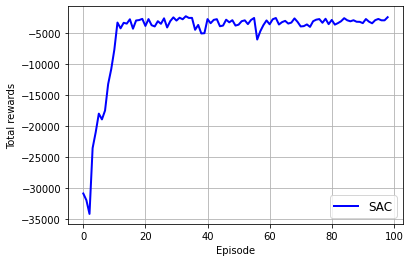

In [2]:


plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'SAC')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)

In [3]:
# TEST   
episode = 0
s = env.reset()    
h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))
h_in = h_out
score = 0
while episode < 3:  # episode loop
    env.render()
    a, _= pi(torch.from_numpy(s).float())
    s_prime, r, done, info = env.step([2.0*a.item()])  # take a random action
    s = s_prime
    h_in = h_out
    sleep(0.01)
    if done:
        env.close()
    score = score + r
    if done:
        episode = episode + 1
        print('Episode: {} Score: {}'.format(episode, score))
        state = env.reset()
env.close()    




Episode: 1 Score: -119.83219756354566
Episode: 2 Score: -253.49629419945012
Episode: 3 Score: -384.43941450299195
